# EA solution to the TSP problem

In [647]:
import logging
from itertools import combinations
from itertools import accumulate
from dataclasses import dataclass
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
#from pyvis.network import Network
from matplotlib import pyplot as plt

from tqdm.auto import tqdm
from icecream import ic

logging.basicConfig(level=logging.DEBUG)

In [648]:
CITIES = pd.read_csv('cities/us.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
# It return r-length tuples in sorted order with no repeated elements 
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()

,name,lat,lon
0,Abilene,32.454514,-99.738147
1,Akron,41.080456,-81.521429
2,Albuquerque,35.105552,-106.647388
3,Alexandria,38.818343,-77.082026
4,Allen,33.107224,-96.674676


In [649]:
def tsp_cost(tsp):

    assert tsp[0] == tsp[-1]

    assert set(tsp) == set(range(len(CITIES))), print(tsp)

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

In [650]:
TAU = 3

@dataclass
class Individual:
    tsp: list
    fitness: float = None

#the fitness is the negative of the distance: in this way I can maximize it.
#in order for the cost to be computed, I make the path cyclic by adding the first city at the end
def fitness(ind: Individual):
    if ind.fitness is None:
        ind.tsp.append(ind.tsp[0])
        ind.fitness = -tsp_cost(ind.tsp)
        ind.tsp.pop()
    return ind.fitness

#parent selection -> tournament selection
def parent_selection(population):
    candidates = sorted(np.random.choice(population, TAU), key=fitness, reverse=True)
    return candidates[0]


def insert_mutation(p: Individual):
    newTsp = p.tsp.copy()
    i, j = np.random.choice(len(newTsp), 2, replace=False)
    if i > j: i, j = j, i
    temp = newTsp[j]
    newTsp[i+2:j+1]=newTsp[i+1:j]
    newTsp[i+1]=temp
    return Individual(newTsp)

def inversion_mutation(p: Individual):
    newTsp = p.tsp.copy()
    i, j = np.random.choice(len(newTsp), 2, replace=False)
    if i > j: i, j = j, i
    newTsp[i:j+1] = newTsp[i:j+1][::-1]
    return Individual(newTsp)

#takes one gene from the first parent and one edge from the second parent
def inver_over_xover(p1: Individual, p2: Individual):
    newTsp = p2.tsp.copy()
    i = np.random.choice(len(newTsp)-1)
    #Takes two adjacent nodes from the first parent -> Retrieves an edge
    node1, node2 = p1.tsp[i], p1.tsp[i+1]
    #Finds the indexes of the nodes in the second parent
    id1 = newTsp.index(node1)
    id2 = newTsp.index(node2)   
    if id1 > id2: 
        id1, id2 = id2, id1 
        node2 = node1
    #recreate the edge in the offspring and reverse what's in between
    newTsp[id1+2:id2+1] = newTsp[id1+1:id2][::-1]
    newTsp[id1+1] = node2 
    
    return Individual(newTsp)

In [651]:
def greedyFirstSolution_1(firstCity):
    
    city = firstCity

    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    visited[city] = True
    
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        visited[closest] = True
        city = closest
        tsp.append(int(city))
        
    return tsp

In [652]:
def greedyFirstSolution_2(canStartFrom):
    
    if np.all(canStartFrom == False):
        canStartFrom = np.full(len(CITIES), True)
        
    city = np.random.choice(np.where(canStartFrom)[0])
    canStartFrom[city] = False

    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    visited[city] = True
    
    
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        visited[closest] = True
        city = closest
        tsp.append(int(city))
        
    return tsp

## EA Implementation

The implementation starts form a population made of greedy solutions. The greedy solutions are obtained by selecting the nearest neighbor at each step. 

There are 2 versions of the greedyFirstSolution function:

- **greedyFirstSolution_1**: the city from which the computation starts is randomly selected. This means that we can have copies of the same individual in the starting population.
- **greedyFirstSolution_2**: the city from which the computation starts is chosen randomly among the cities that have not been visited yet. This reduces the number of copies of the same individual in the starting population (it zeroes them if the population size is smaller than the number of cities).

EA characteristics:

* Hyper-modern GA flow
* Representation: one-time items
* Parent selection: tournament selection
* Crossover: inver-over
* Mutation: can be chosen between insert mutation and inversion mutation
* Population model: can be chosen between generational and steady-state


In [653]:
POPULATION_SIZE = 100
OFFSPRING_SIZE = 1000
MAX_GENERATIONS = 1000
MUTATION_PROBABILITY = .4
STEADY_STATE = True
ADAPTIVE_PROBABILITY = False

history = list()
steady = 0

#define population 
#With the following line of code I implicitly accept copies of the same first solution
#population = [Individual(greedyFirstSolution_1(np.random.randint(len(CITIES)))) for _ in range(POPULATION_SIZE)]

#with this variation I have less duplicates
canStartFrom = np.full(len(CITIES), True)
population = [Individual(greedyFirstSolution_2(canStartFrom)) for _ in range(POPULATION_SIZE)]

mutation = inversion_mutation
#mutation = insert_mutation

for i in population:
    i.fitness = fitness(i)

for g in tqdm(range(MAX_GENERATIONS)):
    
    if ADAPTIVE_PROBABILITY:
        MUTATION_PROBABILITY = 0.1 +0.8*(np.clip(g,0,1))
    
    offspring = list()
    #hypermodern approach -> we choose if we want to do mutation or crossover
    for _ in range(OFFSPRING_SIZE):
        if np.random.random() < MUTATION_PROBABILITY:
            #do mutation
            p1 = parent_selection(population)
            o = mutation(p1)
        else:
            #do crossover
            p1 = parent_selection(population)
            p2 = parent_selection(population)
            o = inver_over_xover(p1, p2)
        offspring.append(o)
    
    
    for i in offspring:
        i.fitness = fitness(i)
    
    if STEADY_STATE:
        #steady state -> we replace the worst individuals
        population.extend(offspring)
        population = sorted(population, key=fitness, reverse=True)[:POPULATION_SIZE]
    else:
        #generational -> we replace the whole population
        population = sorted(offspring, key=fitness, reverse=True)[:POPULATION_SIZE]
    max_fitness = max(population, key=fitness).fitness
    history.append(max_fitness)
    
    #anticipated exit
    if len(history) >=2 and max_fitness == history[-2]:
        steady += 1
    else:
        steady = 0
    if steady == 300:
        break

history.append(max_fitness)
print(f"Shortest distance: {-max_fitness}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Shortest distance: 40580.01287937341


## Results

### Configuration 1

* `POPULATION_SIZE = 100`
* `GENERATIONS = 1000`
* `MUTATION_PROBABILITY = 0.6`
* `OFFSPRING_SIZE = 100`
* `TAU = 2`
* `STEADY_STATE = True`
* `greedyFirstSolution_1`
* `ADAPTIVE_PROBABILITY = False`
* `mutation = insert_mutation`

The problem with this configuration is that 1000 generations are too many for Vanuatu but too few for Russia, USA and China.

* Vanuatu: 1345.5 km
* Italy: 4267.5 km
* Russia: 36028.4 km
* US:  42402.3 km
* China: 59959.3 km


### Configuration 2

* `POPULATION_SIZE = 100`
* `GENERATIONS = len(CITIES)\*10`
* `MUTATION_PROBABILITY = 0.6`
* `OFFSPRING_SIZE = 7*POPULATION_SIZE`
* `TAU = 2`
* `STEADY_STATE =  False`
* `ADAPTIVE_PROBABILITY = False`
* `mutation = insert_mutation`
* `greedyFirstSolution_2`

This configuration gives better results, however the time required to compute the solution is too high. For this reason I added a stopping criterion based on the number of generations without improvement.

* Vanuatu: 1345.54 km
* Italy: 4172.76 km
* Russia: 35536.15 km
* US:  41574.26 km
* China: 59306.17 km


### Confguration 3 

* `POPULATION_SIZE = 200`
* `OFFSPRING_SIZE = 7*POPULATION_SIZE`
* `MAX_GENERATIONS = len(CITIES) * 10`
* `MUTATION_PROBABILITY = .1`
* `STEADY_STATE = False`
* `ADAPTIVE_PROBABILITY = True`
* `TAU = 2`
* `greedyFirstSolution_2`
* `mutation = insert_mutation`

In this configuration I tried to implement an adaptive solution for the mutation probability. The idea is to start with a low mutation probability and a high crossover probability (incentivize exploration) and then increase the mutation probability and decrease the crossover probability (incentivize exploitation). The results are better for the bigger configurations. 

* Vanuatu: 1345.54 km
* Italy: 4272.83 km
* Russia: 35326.34 km
* US: 41941.84 km
* China: 56274.36 km

### Confguration 4

* `POPULATION_SIZE = 100`
* `OFFSPRING_SIZE = 1000`
* `MAX_GENERATIONS = 1000`
* `MUTATION_PROBABILITY = .4`
* `STEADY_STATE = True`
* `ADAPTIVE_PROBABILITY = False`
* `TAU = 3`
* `greedyFirstSolution_2`
* `mutation = inversion_mutation`

This solution gives the best results so far for the biggest problem and takes way less time to compute than configuration 2 and 3. So far it is the best configuration.

* Vanuatu: 1345.54 km
* Italy: 4274.80 km
* Russia: 34782.93 km
* US: 40580.01 km
* China: 54693.5 km

## Visualization

### Fitness Plot

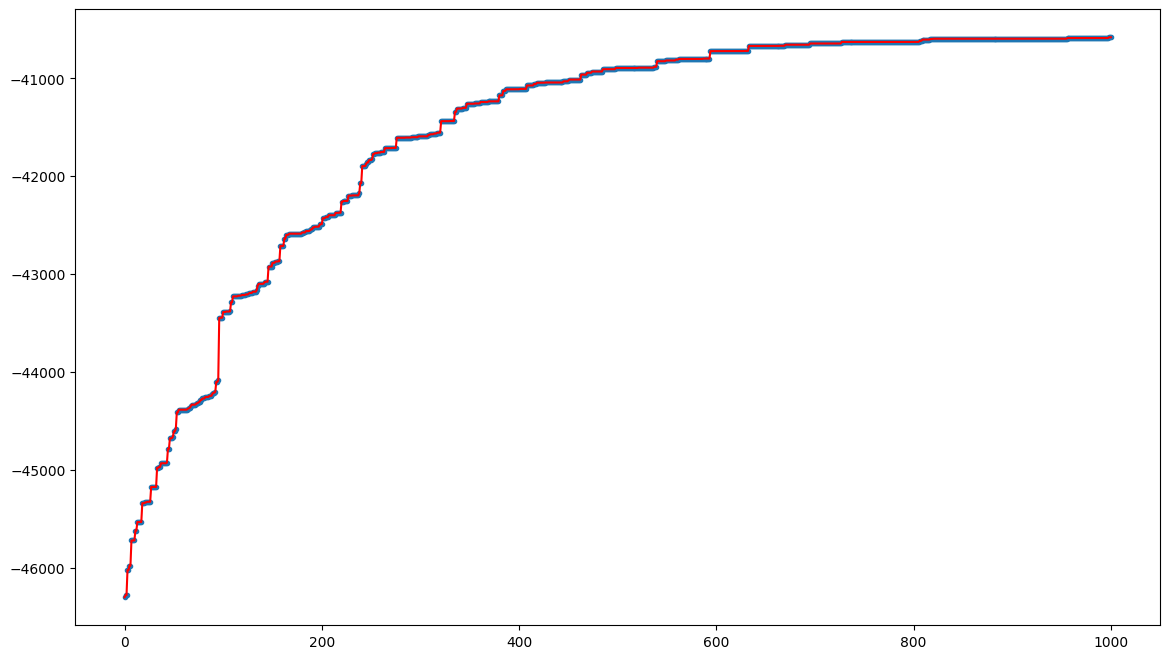

In [654]:
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

### Network visualization

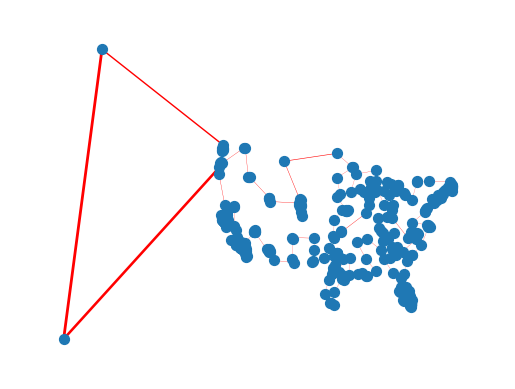

<Figure size 1400x800 with 0 Axes>

In [ ]:
EDGE_SIZE = 2

tsp = max(population, key=fitness).tsp

G = nx.Graph()
tspEdges = [(CITIES.at[tsp[i], 'name'], CITIES.at[tsp[i+1], 'name']) for i in range(len(tsp)-1)]
tspWidth = [DIST_MATRIX[tsp[i], tsp[i+1]] for i in range(len(tsp)-1)]
tspWidth = [(w/np.max(tspWidth))*EDGE_SIZE for w in tspWidth]


for i in range (len(CITIES)-1):
    for j in range (i+1, len(CITIES)):
        if(i!=j):
            G.add_edge(CITIES.at[i, 'name'], CITIES.at[j, 'name'], value=DIST_MATRIX[i,j])
            

pos = {CITIES.at[i, 'name']: (CITIES.at[i, 'lon'], CITIES.at[i, 'lat']) for i in range(len(CITIES))}

#draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50)


# edge width is proportional number of games played
edgewidth = [d['value'] for (u,v,d) in G.edges(data=True)]
edgewidth = [(w/np.max(edgewidth))*EDGE_SIZE for w in edgewidth]

#draws the chosen path
nx.draw_networkx_edges(G, pos, edgelist=tspEdges, width=tspWidth, edge_color='red')
     

if(len(CITIES)<15):
    nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.5, edge_color='#78c7ff') 
    #node labels
    nx.draw_networkx_labels(G, pos, verticalalignment='bottom', font_size=10, font_family='sans-serif')
    #edge weight labels -> too messy for large graphs
    edge_labels = nx.get_edge_attributes(G, 'value')
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, font_size=6, edge_labels=edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.figure(figsize=(14, 8))
plt.show()